# **1. Introduction**

## Résolution des EDP semi-linéaires par BSDE et Deep Learning

### Contexte et Motivation
Les équations aux dérivées partielles (EDP) sont utilisées dans de nombreux domaines comme la physique, la finance et l'ingénierie. Cependant, la résolution numérique des EDP en **grande dimension** souffre du **fléau de la dimension**.

Les méthodes classiques comme les différences finies et les éléments finis deviennent inefficaces lorsque la dimension $d$ est grande( typique quand $d\geq 3$).

Les **Équations Différentielles Stochastiques Rétrogrades (EDSR)** offrent une reformulation stochastique d'une certaine classe d'EDP, ce qui permet de les résoudre par des méthodes de Monte Carlo et d'utiliser **les réseaux de neurones profonds**.

###  Objectif
L'objectif est :
- Expliquer la relation entre **EDP semi-linéaire et BSDE**
- Présenter **le schéma d'Euler** pour l'approximation
- Implémenter un solveur Deep BSDE
- Appliquer cette méthode à la **tarification d’une option basket en grande dimension**



# **2. Théorie : Lien entre EDP et BSDE**
"""
### Formulation d’une EDP semi-linéaire
Nous considérons une EDP parabolique semi-linéaire de la forme :
$$
\partial_t u(t, x) + \frac{1}{2} \text{Tr}(\sigma \sigma^T \nabla^2 u) + \mu \cdot \nabla u + f(t, x, u, \sigma^T \nabla u) = 0
$$
avec la condition terminale :
$$
u(T, x) = g(x)$$

où :
- $u(t, x)$ est la fonction inconnue,
- $\mu$ est un vecteur connu( drift),
- $\sigma$ est une matrice connue ( la volatilité) ,
- $f$ est une fonction de coût,
- $g$ est une condition finale.

### Reformulation en BSDE
En utilisant un mouvement brownien $(W_t)$, on peut écrire le processus stochastique associé :
$$
X_t = \xi + \int_0^t \mu(s, X_s) ds + \int_0^t \sigma(s, X_s) dW_s
$$

La solution $u(t, X_t)$ de l’EDP peut être obtenue en résolvant la **BSDE associée** :
$$
Y_t = g(X_T) + \int_t^T f(s, X_s, Y_s, Z_s) ds - \int_t^T Z_s dW_s
$$

avec $Z_s = \sigma^T \nabla u(s, X_s)$.

### Démonstration du lien entre EDP et BSDE
L'idée principale est d'utiliser **le lemme d'Itô** pour exprimer $u(t, X_t)$ et relier cela à $Y_t$.

En appliquant la formule d’Itô à $u(t, X_t)$ :
$$
\begin{aligned}
    du(t, X_t) &= \partial_t u dt + \nabla u \cdot dX_t + \frac{1}{2} \text{Tr}(\sigma \sigma^T \nabla^2 u) dt \\
    &= \left(\partial_t u + \frac{1}{2} \text{Tr}(\sigma \sigma^T \nabla^2 u) + \mu \cdot \nabla u \right) dt + \sigma^T \nabla u dW_t
\end{aligned}
$$
Par unicité de la solution de la BSDE( sous des condition sur le driver $f$), on obtient :
$$
Y_t = u(t, X_t), \quad Z_t = \sigma^T \nabla u(t, X_t)
$$
Ainsi, **résoudre l’EDP revient à estimer $Y_t$ et $Z_t$**, ce qui est l’objectif du Deep BSDE Solver.


#  Schéma d'Euler pour l'approximation
Pour l'implementation nous allons utiliser le schema d'euler

Nous discrétisons l'intervalle temporel $[0,T]$ en $N$ sous-intervalles équidistants :
$$
0=t_0 < t_1 < \dots < t_N = T, \quad \Delta t = \frac{T}{N}.
$$

Nous utilisons le **schéma d'Euler-Maruyama** pour approximer le processus stochastique :
$$
\tilde X_{{n+1}} = \tilde X_{n}
+ \mu(t_n, \tilde X_{n}) \Delta t
+ \sigma(t_n, \tilde X_{n}) (W_{t_{n+1}} - W_{t_n}).
$$

Le processus rétrograde est discrétisé comme suit :
$$
\tilde Y_{{n+1}} = \tilde Y_{n}
- f(t_n, \tilde X_{n}, \tilde Y_{n}, \tilde Z_{n}) \Delta t
+ \tilde Z_{n} \cdot ( W_{t_{n+1}} - W_{t_n}).
$$

L'objectif est d'approximer $\tilde Z_n \approx \sigma^T \nabla u(t_n, \tilde X_n)$( en vertu du théorème d'approximation universelle) via un réseau de neurones ainsi que le gradient à chaque pas de temps et $\tilde Y_0 \approx u(0, x)$ comme un paramètre de notre réseau.

Ainsi la fonction de perte utilisée est basée sur l'erreur quadratique moyenne :
$$
\mathcal{L} = \mathbb{E} \left[ \left| \tilde Y^{\theta}_N - g(\tilde X_N) \right|^2 \right].
$$


Nous allons commencer par implemeter les fonctions qui nous permettra de simuler $\{\tilde X_{i}\}_{i=0, \ldots, N}$ et $\{W_{t_i}\}_{i=0, \ldots, N}$ de sorte que $ X_0 = x$ et $( W_{t_{n+1}} - W_{t_n}) \sim \mathsf{N}(0,(t_{n+1} - t_n) I_{d\times d})$ est une distribution normal.  Aussi dans le cas particulier  $\mu(t,X_t) \equiv 0$ and $\sigma(t,X_t) \equiv \sigma I_{d \times d}$. Et tracer quelque trajectoire

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import models,transforms
from torchsummary import summary


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de : {device}")

Utilisation de : cuda


In [ ]:
T = 1.0
dim = 100

N = 20

dt = T/N
t_space = np.linspace(0, T, N + 1)
x = np.zeros(dim)

sigma = np.sqrt(2)

In [ ]:
def draw_X_dw(num_sample, x):
    dim = x.shape[0]
    dW = torch.randn((num_sample, dim, N), dtype=torch.float32) * torch.sqrt(torch.tensor(dt, dtype=torch.float32))
    X = torch.zeros((num_sample, dim, N+1), dtype=torch.float32)
    X[:, :, 0] = x.unsqueeze(0).expand(num_sample, -1)
    for i in range(N):
        X[:, :, i+1] = X[:, :, i] + sigma * dW[:, :, i]

    return X, dW

Text(0, 0.5, '$X_t$')

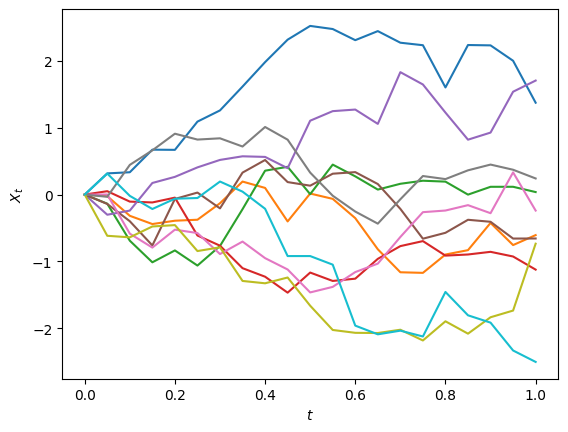

In [ ]:
num_sample  = 10
X, dW = draw_X_dw(num_sample, torch.zeros(1))


fig,ax = plt.subplots(1)
for i in range(num_sample):
    ax.plot(t_space,X[i,0,:])
ax.set_xlabel('$t$')
ax.set_ylabel('$X_t$')

Maintenant nous allons simuler les $\{\tilde Y_{i}\}_{i=0, \ldots, N}$ en nous servant des reseaux de neuronnes car il faut approximer les $\tilde Z_{i}$ a cahque pas de temps.
$$
\tilde Y_{{n+1}} = \tilde Y_{n}
- f(t_n, \tilde X_{n}, \tilde Y_{n}, \tilde Z_{n}) \, (t_{n+1} - t_n)
+ \tilde Z_{n} \cdot (W_{t_{n+1}} - W_{t_n}), \qquad \tilde Y_N = g(\tilde X_N),
$$

In [ ]:
class BSDEModel(nn.Module):
    def __init__(self, dim, N):
        """
        Modèle BSDE basé sur PyTorch.

        Arguments :
        - dim : Dimension du problème.
        - N : Nombre de pas de temps.
        """
        super(BSDEModel, self).__init__()

        self.dim = dim
        self.N = N

        # Initialisation de u0 et grad u0
        self.u0 = nn.Parameter(torch.FloatTensor(1).uniform_(0.1, 0.3).to(device))
        self.gradu0 = nn.Parameter(torch.FloatTensor(1, dim).uniform_(-1e-1, 1e-1).to(device))

        # Définition des couches réseau pour approximer ∇u(t, x)
        self.gradui = nn.ModuleList()

        for _ in range(N - 1):
            self.gradui.append(nn.Sequential(
                nn.BatchNorm1d(dim),
                nn.Linear(dim, dim + 10, bias=True),
                nn.LeakyReLU(),
                nn.Linear(dim + 10, dim, bias=True),
                nn.BatchNorm1d(dim)
            ).to(device))

    def forward(self, x, t_index):
        return self.gradui[t_index](x)


In [ ]:
def Y_Z_draw(inp, model, f_func):
    X, dW = inp
    num_sample = X.shape[0]
    y = torch.ones((num_sample, 1), dtype=torch.float32, device=model.u0.device) * model.u0

    z = torch.ones((num_sample, 1, dim), dtype=torch.float32, device=model.gradu0.device) * model.gradu0

    for i in range(N-1):
        t = t_space[i]
        y = y - f_func(t, X[:, :, i], y, z).to(y.device)*dt + torch.sum(z*dW[:, :, i], axis=1, keepdim=True)
        z = model.gradui[i](X[:, :, i + 1]).to(y.device) / dim

    t = t_space[N-1]
    y = y - f_func(t, X[:, :, N-1], y, z).to(y.device) * dt + torch.sum(z*dW[:, :, N-1], axis=1, keepdim=True)

    return y

En appliquant cette fonction, nous pouvons gener pour chaque trajectoire $\{\tilde X_{i}\}_{i=0,\ldots,N}$ des realisation de $\tilde Y_N$ etant donné les parametre inconnu de notre reseaux.

Nous allons maintenant implementater la fonction de perte et la fonction d'entrainement

In [ ]:
def loss_fn(inp, model, f_func, g_func):
    X, _ = inp
    y_pred = Y_Z_draw(inp, model, f_func)

    y = g_func(X[:,:, -1])

    loss = torch.mean(torch.square(y - y_pred))
    return loss

In [ ]:
def train(inp, model, f_func, g_func, epochs, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(inp, model, f_func, g_func)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}")
    return losses


# Modification de la fonction d'entrainement pour l'application simple
def train_app(inp, model, f_func, g_func, epochs, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    prices = []
    L1_rel_errors = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(inp, model, f_func, g_func)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Estimation de u(0, x) et erreur relative
        if epoch % 100 == 0:
            with torch.no_grad():
                y_pred = Y_Z_draw(inp, model, f_func).mean().item()
                prices.append(y_pred)

                y_exact = torch.exp(-torch.tensor(t_space[-1])) * torch.cos(torch.sum(inp[0][:, :, -1], dim=1, keepdim=True)).mean().item()
                L1_rel = abs(y_pred - y_exact) / abs(y_exact)
                L1_rel_errors.append(L1_rel)

                print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}, u(0,x): {y_pred:.4f}, L1_rel: {L1_rel:.6f}")

    return losses, prices, L1_rel_errors

### Application tres simple

On peut prendre une équation avec une solution exacte connue, comme :

$$
\frac{\partial u}{\partial t} + \frac{1}{2} \Delta u - u = 0, \quad u(T,x) = e^{-\beta T} \cos\left( \sum x_i \right).
$$

Avec une solution exacte donnée par :

$$
u(t,x) = e^{-\beta t} \cos\left( \sum x_i \right).
$$




Epoch 0/500, Loss: 0.598103, u(0,x): 0.3801, L1_rel: 2.226238
Epoch 100/500, Loss: 0.000324, u(0,x): 0.3195, L1_rel: 1.712056
Epoch 200/500, Loss: 0.000008, u(0,x): 0.3202, L1_rel: 1.718312
Epoch 300/500, Loss: 0.000001, u(0,x): 0.3202, L1_rel: 1.718278
Epoch 400/500, Loss: 0.000000, u(0,x): 0.3202, L1_rel: 1.718280


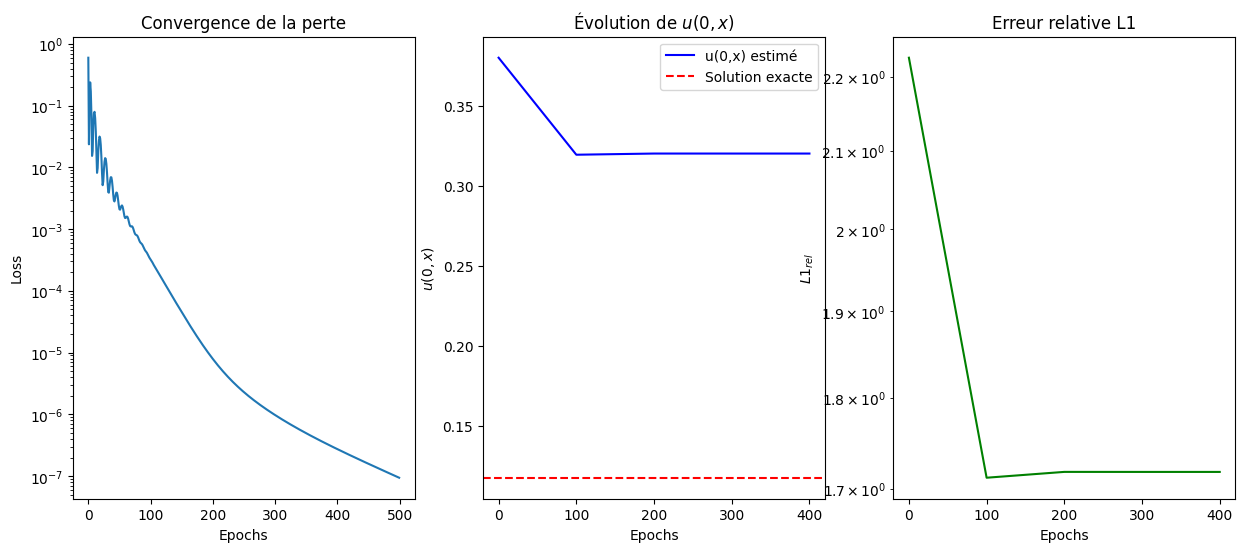

In [ ]:

def f_func(t, X, y, z):
    return -y

def g_func(X):
    return torch.cos(torch.sum(X, dim=1, keepdim=True))

X, dW = draw_X_dw(num_sample, torch.zeros(dim, device=device))

model = BSDEModel(dim, N).to(device)

# Entraînement du modèle
epochs = 500
losses, prices, L1_rel_errors = train_app((X.to(device), dW.to(device)), model, f_func, g_func, epochs, lr=0.001)

# Solution exacte
Y_exact = torch.exp(-torch.tensor(t_space[-1])) * torch.cos(torch.sum(X[:, :, -1], dim=1, keepdim=True))

# Affichage des résultats
fig, ax = plt.subplots(1, 3, figsize=(15, 6))

# Convergence de la loss
ax[0].semilogy(range(epochs), losses, label="Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Convergence de la perte")

# Évolution de u(0, x)
ax[1].plot(range(0, epochs, 100), prices, label="u(0,x) estimé", color="blue")
ax[1].axhline(y=Y_exact.mean().item(), color="r", linestyle="--", label="Solution exacte")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("$u(0,x)$")
ax[1].set_title("Évolution de $u(0,x)$")
ax[1].legend()

# Erreur relative L1_rel
ax[2].semilogy(range(0, epochs, 100), L1_rel_errors, label="L1_rel", color="green")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("$L1_{rel}$")
ax[2].set_title("Erreur relative L1")

plt.show()

## BDSE et Black Schole en grande dimension

Notre But est de trouver le prix d'une option basket en utilisant la methode BSDE ensuite comparer le resultat au prix calculer par methode de monte Carlo.

La formulation mathématique de l'EDP d'une option basket en dimension $d$ s'écrit :

$$
\frac{\partial u}{\partial t} + \frac{1}{2} \sum_{i=1}^{d} \sigma_i^2 S_i^2 \frac{\partial^2 u}{\partial S_i^2} + r \sum_{i=1}^{d} S_i \frac{\partial u}{\partial S_i} - r u = 0,
$$

avec la condition terminale pour une option call basket :

$u(T, S) = \max\left( \frac{1}{d} \sum_{i=1}^{d} S_i - K, 0 \right),$

où :

$S = (S_1, S_2, \dots, S_d)$ sont les prix des actifs sous-jacents,

$r$ est le taux d'intérêt sans risque,


$\sigma = (\sigma_1, \sigma_2, \dots, \sigma_d)$ est la volatilité,

$K$ est le prix d'exercice de l'option,
$u(t, S)$ est la valeur de l'option à l'instant \(t\).


L'équation peut être réécrite sous la forme d'une BSDE :

$$
Y_t = g(X_T) + \int_t^T f(s, X_s, Y_s, Z_s) \, ds - \int_t^T Z_s \, dW_s
$$
avec :

**Processus forward (modèle de Black-Scholes en grande dimension)**
$$
dS_{t_i} = r S_{t_i} \, dt + \sigma_i S_{t_i} \, dW_{t_i}, \quad S_{0_i} = S_i
$$

**Fonction de coût**

$$
f(t, S, Y, Z) = -rY
$$

**Condition terminale**

$$
g(S) = \max\left( \frac{1}{d} \sum_{i=1}^{d} S_i - K, 0 \right)
$$


In [ ]:
class DeepBSDEBlackScholes(nn.Module):
    def __init__(self, d=100, T=1.0, N=50, r=0.05, sigma=0.2, K=100, lr=0.001):
        super(DeepBSDEBlackScholes, self).__init__()

        # Paramètres de Black-Scholes
        self.d = d
        self.T = T
        self.N = N
        self.dt = T / N
        self.r = r
        self.sigma = sigma
        self.K = K
        self.lr = lr

        self.u0 = nn.Parameter(torch.tensor([1.0], dtype=torch.float32, device=device))
        self.gradu0 = nn.Parameter(torch.zeros(1, d, device=device))

        # Réseau de neurones pour approximer les gradients Z_t
        self.gradui = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d, d + 10, bias=True),
                nn.ReLU(),
                nn.Linear(d + 10, d+20, bias=True),
                nn.ReLU(),
                nn.Linear(d + 20, d, bias=True),
            ).to(device) for _ in range(N - 1)
        ])

    def draw_X_dW(self, num_sample, S0):
        """ Génère les trajectoires du modèle Black-Scholes et les incréments dW. """
        dW = torch.randn((num_sample, self.d, self.N), dtype=torch.float32, device=device) * torch.sqrt(torch.tensor(self.dt, dtype=torch.float32, device=device))
        X = torch.zeros((num_sample, self.d, self.N+1), dtype=torch.float32, device=device)
        X[:, :, 0] = S0.unsqueeze(0).expand(num_sample, -1)

        for i in range(self.N):
            X[:, :, i+1] = X[:, :, i] * (1 + self.r * self.dt + self.sigma * dW[:, :, i])

        return X, dW

    def forward(self, X, dW):
        """ Calcul de Y et Z à chaque instant de temps. """
        num_sample = X.shape[0]
        y = torch.ones((num_sample, 1), device=device) * self.u0
        z = torch.ones((num_sample, 1, self.d), device=device) * self.gradu0

        for i in range(self.N - 1):
            y = y - self.r * y * self.dt + torch.sum(z * dW[:, :, i], axis=1, keepdim=True)
            z = self.gradui[i](X[:, :, i+1]) / self.d

        y = y - self.r * y * self.dt + torch.sum(z * dW[:, :, self.N-1], axis=1, keepdim=True)
        return y

    def payoff(self, X):
        """ Condition terminale : Payoff. """
        return torch.maximum(torch.mean(X, dim=1, keepdim=True) - self.K, torch.tensor(0.0, device=device))

    def loss_fn(self, inp):
        """ Fonction de perte basée sur l'erreur quadratique entre Y_T et g(X_T). """
        X, dW = inp
        y_pred = self.forward(X, dW)
        y_true = self.payoff(X[:, :, -1])
        return torch.mean((y_true - y_pred) ** 2)

    def train_model(self, num_sample=5000, epochs=1000, batch_size=2*64):
        """ Entraînement du modèle BSDE avec suivi des métriques pour les tracés. """
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        losses = []
        prices = []
        L1_rel_errors = []

        S0 = torch.full((self.d,), 100.0, device=device)

        for epoch in range(epochs):

            X_batch, dW_batch = self.draw_X_dW(batch_size, S0)
            optimizer.zero_grad()
            loss = self.loss_fn((X_batch, dW_batch))
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            # Calculer le prix estimé toutes les 100 époques
            if epoch % 100 == 0:
                with torch.no_grad():
                    deep_bs_price = self.forward(X_batch, dW_batch).mean().item()
                    prices.append(deep_bs_price)

                    # Estimation de l'erreur relative L1_rel
                    exact_price = torch.mean(self.payoff(X_batch[:, :, -1])).item()
                    L1_rel = abs(deep_bs_price - exact_price) / abs(exact_price)
                    L1_rel_errors.append(L1_rel)

                    print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}, Prix estimé: {deep_bs_price:.4f}, L1_rel: {L1_rel:.6f}")

        return losses, prices, L1_rel_errors

    def monte_carlo(self, num_sample=5000, confidence_level=0.95):
        """ Estimation du prix par la méthode Monte Carlo classique avec intervalle de confiance. """
        S0 = torch.full((self.d,), 100.0, device=device)
        X, _ = self.draw_X_dW(num_sample, S0)

        # Calcul du prix Monte Carlo
        payoff_values = self.payoff(X[:, :, -1]).cpu().detach().numpy()
        mean_price = np.mean(payoff_values)
        std_dev = np.std(payoff_values)

        # Calcul de l'intervalle de confiance à 95%
        confidence_interval = 1.96 * std_dev / np.sqrt(num_sample)
        lower_bound = mean_price - confidence_interval
        upper_bound = mean_price + confidence_interval

        return mean_price, lower_bound, upper_bound

    def compare_methods(self, num_sample=5000, epochs=1000):
        """ Compare le Deep BSDE Solver avec la méthode Monte Carlo. """
        print("Entraînement du modèle Deep BSDE...")
        losses, prices, L1_rel_errors = self.train_model(num_sample, epochs, batch_size=2*64)

        mc_price, mc_lower, mc_upper = self.monte_carlo(num_sample)

        print(f"\nPrix avec Deep BSDE Solver : {prices[-1]:.4f}")
        print(f"Prix avec Monte Carlo : {mc_price:.4f}")
        print(f"Intervalle de confiance à 95% pour Monte Carlo : [{mc_lower:.4f}, {mc_upper:.4f}]")

        # Affichage des graphiques
        fig, ax = plt.subplots(1, 3, figsize=(15, 6))

        # Convergence de la perte
        ax[0].semilogy(range(epochs), losses, label="Loss")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        ax[0].set_title("Convergence de la perte")

        # Évolution de u(0, x)
        ax[1].plot(range(0, epochs, 100), prices, label="Prix estimé BSDE", color="blue")
        ax[1].axhline(y=mc_price, color="r", linestyle="--", label="Prix Monte Carlo")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("$u(0,x)$")
        ax[1].set_title("Évolution de $u(0,x)$")
        ax[1].legend()

        # Erreur relative L1_rel
        ax[2].semilogy(range(0, epochs, 100), L1_rel_errors, label="L1_rel", color="green")
        ax[2].set_xlabel("Epochs")
        ax[2].set_ylabel("$L1_{rel}$")
        ax[2].set_title("Erreur relative L1")

        plt.show()


Entraînement du modèle Deep BSDE...
Epoch 0/1100, Loss: 58.501232, Prix estimé: 2.8039, L1_rel: 0.489365
Epoch 100/1100, Loss: 25.679661, Prix estimé: 2.1381, L1_rel: 0.663828
Epoch 200/1100, Loss: 15.264096, Prix estimé: 2.9396, L1_rel: 0.495718
Epoch 300/1100, Loss: 11.573073, Prix estimé: 3.6891, L1_rel: 0.408204
Epoch 400/1100, Loss: 7.670541, Prix estimé: 3.6978, L1_rel: 0.336048
Epoch 500/1100, Loss: 7.513767, Prix estimé: 3.8405, L1_rel: 0.268772
Epoch 600/1100, Loss: 4.414668, Prix estimé: 4.6039, L1_rel: 0.144854
Epoch 700/1100, Loss: 3.980386, Prix estimé: 5.9900, L1_rel: 0.076805
Epoch 800/1100, Loss: 3.923805, Prix estimé: 5.5924, L1_rel: 0.080199
Epoch 900/1100, Loss: 4.506082, Prix estimé: 5.1862, L1_rel: 0.058455
Epoch 1000/1100, Loss: 5.884323, Prix estimé: 6.0169, L1_rel: 0.033541

Prix avec Deep BSDE Solver : 6.0169
Prix avec Monte Carlo : 6.0273
Intervalle de confiance à 95% pour Monte Carlo : [5.9369, 6.1176]


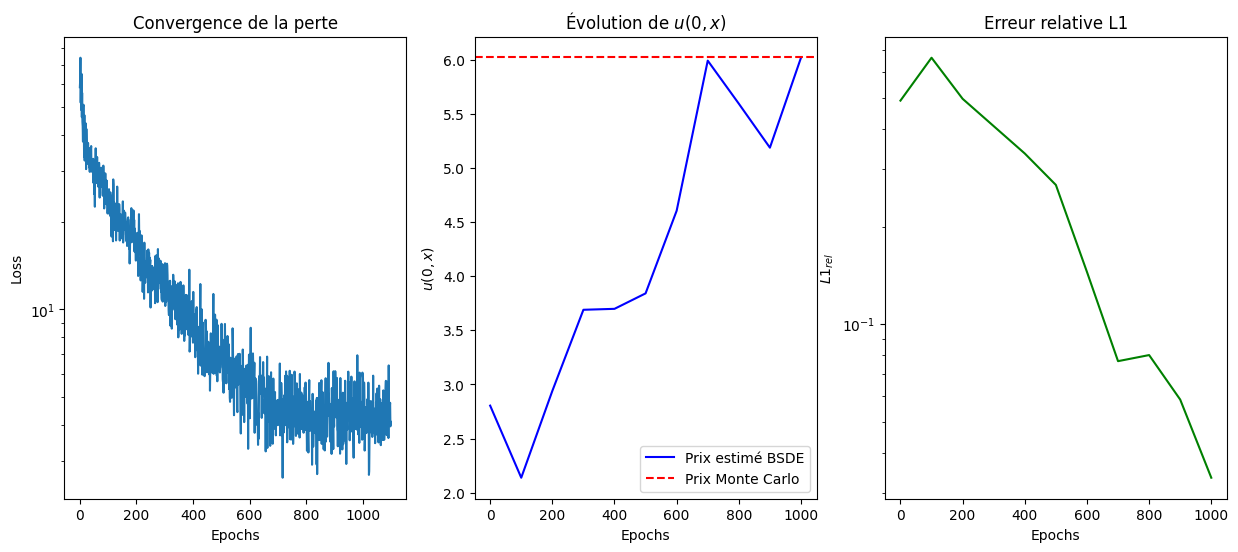

In [ ]:
# Création du modèle
model = DeepBSDEBlackScholes(d=10, T=1.0, N=50, r=0.05, sigma=0.2, K=100, lr=0.01)

# Comparaison des méthodes
model.compare_methods(num_sample=15000, epochs=1100)


Entraînement du modèle Deep BSDE...
Epoch 0/1100, Loss: 27.416203, Prix estimé: 7.9429, L1_rel: 0.500367
Epoch 100/1100, Loss: 16.520231, Prix estimé: 2.2748, L1_rel: 0.575328
Epoch 200/1100, Loss: 10.101453, Prix estimé: 2.5762, L1_rel: 0.460479
Epoch 300/1100, Loss: 7.859483, Prix estimé: 3.7675, L1_rel: 0.345597
Epoch 400/1100, Loss: 3.624071, Prix estimé: 3.9921, L1_rel: 0.243759
Epoch 500/1100, Loss: 1.781266, Prix estimé: 3.9940, L1_rel: 0.188172
Epoch 600/1100, Loss: 0.820389, Prix estimé: 4.2385, L1_rel: 0.099103
Epoch 700/1100, Loss: 0.610203, Prix estimé: 5.3324, L1_rel: 0.053704
Epoch 800/1100, Loss: 0.553733, Prix estimé: 4.8205, L1_rel: 0.048232
Epoch 900/1100, Loss: 0.692940, Prix estimé: 5.2487, L1_rel: 0.026742
Epoch 1000/1100, Loss: 0.462978, Prix estimé: 5.4453, L1_rel: 0.001826

Prix avec Deep BSDE Solver : 5.4453
Prix avec Monte Carlo : 5.1350
Intervalle de confiance à 95% pour Monte Carlo : [5.0889, 5.1811]


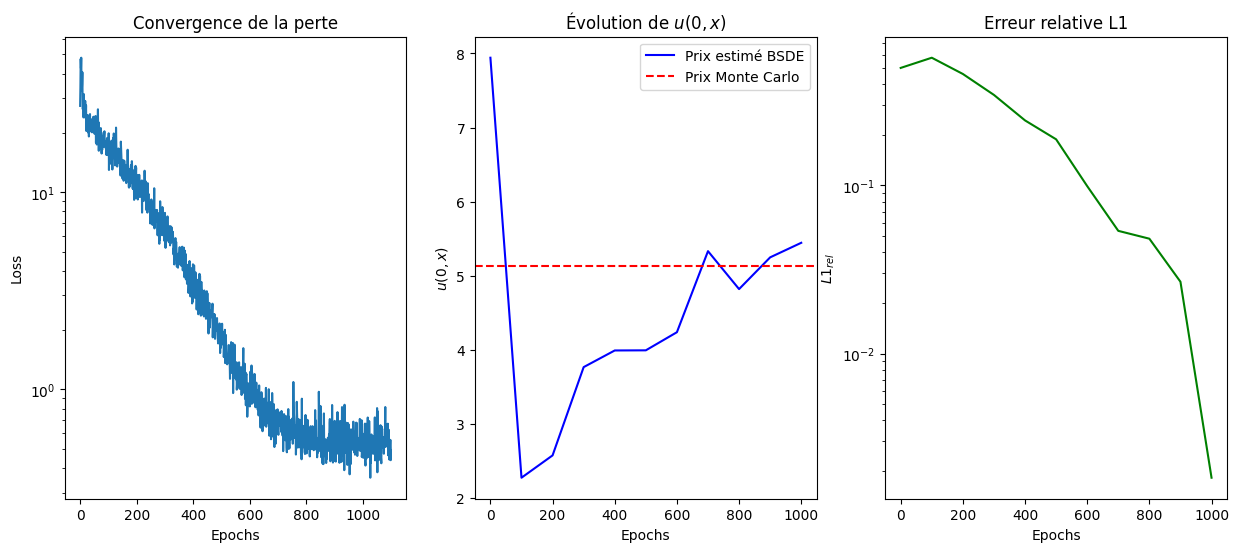

In [ ]:
# d = 50

model = DeepBSDEBlackScholes(d=50, T=1.0, N=50, r=0.05, sigma=0.2, K=100, lr=0.01)

model.compare_methods(num_sample=15000, epochs=1100)

Entraînement du modèle Deep BSDE...
Epoch 0/1100, Loss: 25.022411, Prix estimé: 16.9345, L1_rel: 2.197393
Epoch 100/1100, Loss: 15.910967, Prix estimé: 1.8594, L1_rel: 0.636638
Epoch 200/1100, Loss: 10.704365, Prix estimé: 2.6349, L1_rel: 0.493471
Epoch 300/1100, Loss: 6.858933, Prix estimé: 3.3011, L1_rel: 0.335731
Epoch 400/1100, Loss: 4.985750, Prix estimé: 3.8477, L1_rel: 0.269783
Epoch 500/1100, Loss: 2.461561, Prix estimé: 4.2722, L1_rel: 0.204488
Epoch 600/1100, Loss: 1.213187, Prix estimé: 4.7344, L1_rel: 0.110179
Epoch 700/1100, Loss: 0.610192, Prix estimé: 4.6772, L1_rel: 0.068909
Epoch 800/1100, Loss: 0.397821, Prix estimé: 4.6830, L1_rel: 0.044738
Epoch 900/1100, Loss: 0.231204, Prix estimé: 5.0392, L1_rel: 0.030056
Epoch 1000/1100, Loss: 0.259803, Prix estimé: 5.1689, L1_rel: 0.012936

Prix avec Deep BSDE Solver : 5.1689
Prix avec Monte Carlo : 5.1314
Intervalle de confiance à 95% pour Monte Carlo : [5.0977, 5.1652]


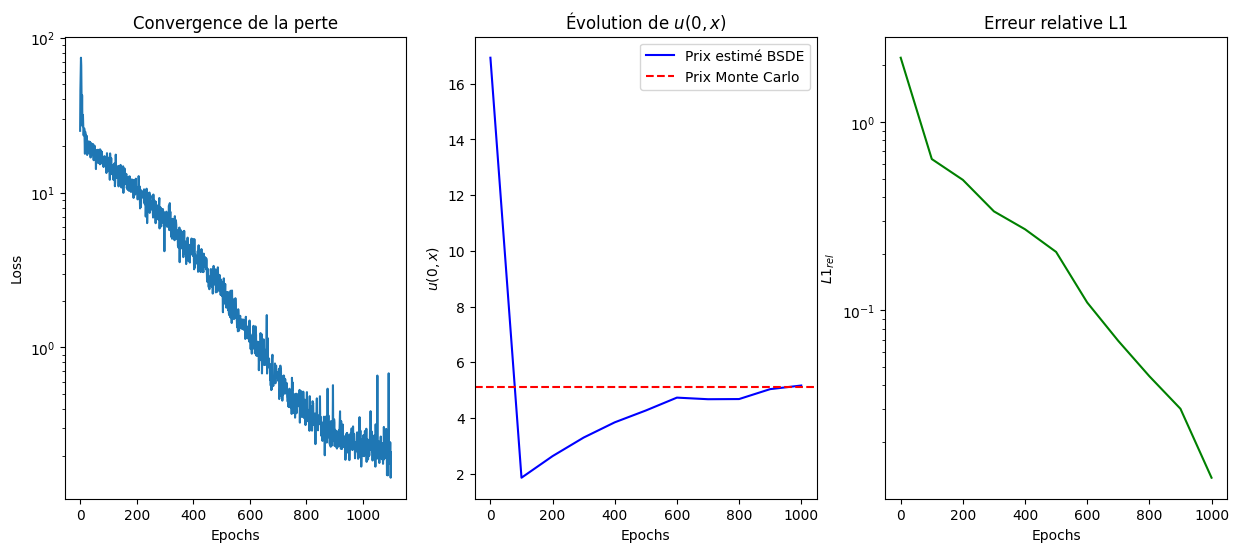

In [ ]:
model = DeepBSDEBlackScholes(d=100, T=1.0, N=50, r=0.05, sigma=0.2, K=100, lr=0.01)

model.compare_methods(num_sample=15000, epochs=1100)

Reference:

[1] Han, J., Jentzen, A., and E, W. Overcoming the curse of dimensionality: Solving high-dimensional partial differential equations using deep learning, Proceedings of the National Academy of Sciences, 115(34), 8505-8510 (2018). [journal] [arXiv]

[2] E, W., Han, J., and Jentzen, A. Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations, Communications in Mathematics and Statistics, 5, 349–380 (2017). [journal] [arXiv]